In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt


/kaggle/input/spam-filter/emails.csv


加载数据集
我所使用的数据集来自UHT，该数据集有2列，5728行。

In [2]:
df = pd.read_csv('/kaggle/input/spam-filter/emails.csv')

来简单看一下数据集的情况

In [3]:
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [4]:
df.shape

(5728, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


数据集中没有缺失的数据


In [6]:
df.isna().sum()

text    0
spam    0
dtype: int64

我们可以发现，本数据集中垃圾邮件有1368个，标记为'1'，非垃圾邮件有4360个，标记为'0'

In [7]:
df['spam'].value_counts()

0    4360
1    1368
Name: spam, dtype: int64

图形化查看数据集

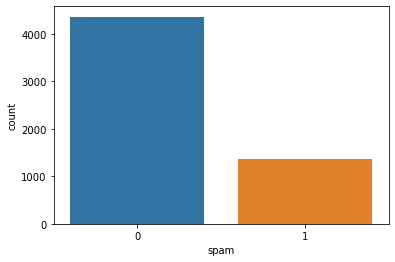

In [8]:
sns.countplot(df['spam'])

### 接下来，我们进行**NLP**的基本流程，利用便利的nltk包

In [9]:
from nltk import word_tokenize

Function that tokenizes each and every email into words and returns it's length

In [10]:
def count_words(text):
    words = word_tokenize(text)
    return len(words)

Applying the function to df['text'] and storing the count in another column

In [11]:
df['count']=df['text'].apply(count_words)

In [12]:
df['count']

0       325
1        90
2        88
3        99
4        53
       ... 
5723    298
5724    245
5725    516
5726    277
5727    445
Name: count, Length: 5728, dtype: int64

In [13]:
df.groupby('spam')['count'].mean()

spam
0    346.835321
1    267.896199
Name: count, dtype: float64

In [14]:
df

,text,spam,count
0,Subject: naturally irresistible your corporate...,1,325
1,Subject: the stock trading gunslinger fanny i...,1,90
2,Subject: unbelievable new homes made easy im ...,1,88
3,Subject: 4 color printing special request add...,1,99
4,"Subject: do not have money , get software cds ...",1,53
...,...,...,...
5723,Subject: re : research and development charges...,0,298
5724,"Subject: re : receipts from visit jim , than...",0,245
5725,Subject: re : enron case study update wow ! a...,0,516
5726,"Subject: re : interest david , please , call...",0,277


# Text Prepreocessing

**Function to Process the text data and 1. Remove Punctuation 2.Stop Words 3.Stemming**

In [15]:
import string
from nltk.corpus import stopwords


In [16]:
def process_text(text):
    no_punc = [char for char in text if char not in string.punctuation]
    no_punc = ''.join(no_punc)
    
    
    return ' '.join([word for word in no_punc.split() if word.lower() not in stopwords.words('english')])

### ***In natural language processing, useless words (data), are referred to as stop words.***

In [17]:
df['text']=df['text'].apply(process_text)

In [18]:
df['text']

0       Subject naturally irresistible corporate ident...
1       Subject stock trading gunslinger fanny merrill...
2       Subject unbelievable new homes made easy im wa...
3       Subject 4 color printing special request addit...
4       Subject money get software cds software compat...
                              ...                        
5723    Subject research development charges gpg forwa...
5724    Subject receipts visit jim thanks invitation v...
5725    Subject enron case study update wow day super ...
5726    Subject interest david please call shirley cre...
5727    Subject news aurora 5 2 update aurora version ...
Name: text, Length: 5728, dtype: object

**After cleaning the text. We will now carry out the process of Stemming to reduce infected words to their root**

In [19]:
df['text'].iloc[0]

'Subject naturally irresistible corporate identity lt really hard recollect company market full suqgestions information isoverwhelminq good catchy logo stylish statlonery outstanding website make task much easier promise havinq ordered iogo company automaticaily become world ieader isguite ciear without good products effective business organization practicable aim hotat nowadays market promise marketing efforts become much effective list clear benefits creativeness hand made original logos specially done reflect distinctive company image convenience logo stationery provided formats easy use content management system letsyou change website content even structure promptness see logo drafts within three business days affordability marketing break make gaps budget 100 satisfaction guaranteed provide unlimited amount changes extra fees surethat love result collaboration look portfolio interested'

#### eg: stemming algorithm reduces the words “chocolates”, “chocolatey”, “choco” to the root word, “chocolate”

In [20]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

In [21]:
def stemming (text):
    return ''.join([stemmer.stem(word) for word in text])

In [22]:
df['text']=df['text'].apply(stemming)

In [23]:
df.head()

,text,spam,count
0,Subject naturally irresistible corporate ident...,1,325
1,Subject stock trading gunslinger fanny merrill...,1,90
2,Subject unbelievable new homes made easy im wa...,1,88
3,Subject 4 color printing special request addit...,1,99
4,Subject money get software cds software compat...,1,53


**Now we will use Count Vectorizer to convert string data into Bag of Words ie Known Vocabulary**


### It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer= CountVectorizer()
message_bow = vectorizer.fit_transform(df['text'])

In [25]:
a = message_bow.toarray()
print(a[0])

[0 0 0 ... 0 0 0]


**Splitting the Data[](http://)**

In [26]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(message_bow,df['spam'],test_size=0.20)

# Creating the Model and it's Evaluation

In [27]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=0)
LR.fit(X_train,y_train)
# nb= MultinomialNB()
# nb.fit(X_train,y_train)
# y_pred = nb.predict(X_test)
y_pred = LR.predict(X_test)


In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       865
           1       0.97      0.98      0.97       281

    accuracy                           0.99      1146
   macro avg       0.98      0.98      0.98      1146
weighted avg       0.99      0.99      0.99      1146



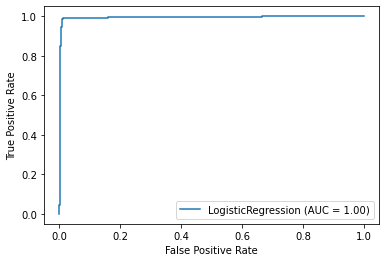

In [30]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(LR,X_test,y_test)

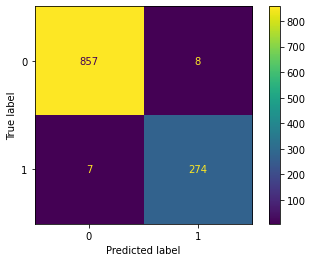

In [31]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(LR,X_test,y_test)

In [38]:
from sklearn.model_selection import KFold, cross_val_score
kfold = KFold(n_splits=5,shuffle=True)
print("Accuracy using Cross Validation is :",np.mean(cross_val_score(LR,message_bow,df['spam'],cv=kfold,scoring="accuracy"))*100," %")

Accuracy using Cross Validation is : 99.05724105870428  %
